In [330]:
#ロジスティック回帰モデルのライブラリインポート
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #3D散布図の描画
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

In [314]:
#データの読み込み
df = pd.read_csv("ks-projects-201801.csv")

In [315]:
display(df.head())

df.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


### カラムの確認

0	ID	管理番号	削除	<br>
1	name	プロジェクト名	利用？	<br>
2	category	第2カテゴリー	利用	<br>
3	main_category	第1カテゴリー	利用	<br>
4	currency	募集した通貨単位	削除	<br>
5	deadline	締切日	利用	<br>
6	goal	目標金額	利用	<br>
7	launched	開始日	利用<br>
8	pledged	最終到達金額	削除	<br>
9	state	プロジェクトの成功可否	利用	<br>
10	backers	支援者数	削除	<br>
11	country	国情報	利用？	<br>
12	usd pledged	到達金額（KICKSTARTER運営換算）	削除	<br>
13	usd_pledged_real	到達金額（Fixer.IO換算）	削除	<br>
14	usd_goal_real	目標金額（Fixer.IO換算）	利用	<br>




### データクレンジングの方針
1．　goal、pledgedを削除する。usd_pledged_real、usd_goal_realを用いるため。<br>
2．　ID、backer、usd_pledgedを削除する。予測に必要ないため。<br>
3．　stateがsuccessfullとfailed以外、削除する。<br>


In [316]:
df2 = df.drop(['ID', 'goal', 'pledged', 'currency','backers', 'usd pledged'], axis=1)
df2.columns

Index(['name', 'category', 'main_category', 'deadline', 'launched', 'state',
       'country', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

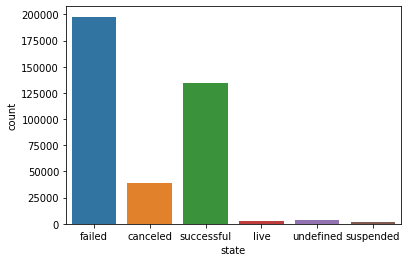

In [317]:
df2['state']
sns.countplot('state',data = df2)

failed        197719
successful    133956
Name: state, dtype: int64

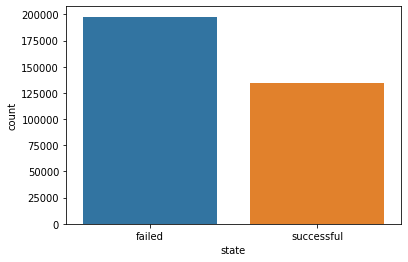

In [318]:
df2 = df2[df2['state'] != 'canceled']
df2 = df2[df2['state'] != 'live']
df2 = df2[df2['state'] != 'undefined']
df2 = df2[df2['state'] != 'suspended']
sns.countplot('state',data = df2)
df2['state'].value_counts()

In [319]:
df2['state'] = df2['state'].replace("failed",0)
df2['state'] = df2['state'].replace("successful",1)
display(df2.head())
df2.describe()
df2.info()

,name,category,main_category,deadline,launched,state,country,usd_pledged_real,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,0,GB,0.0,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,0,US,2421.0,30000.00
2,Where is Hank?,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,0,US,220.0,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,2012-03-17 03:24:11,0,US,1.0,5000.00
5,Monarch Espresso Bar,Restaurants,Food,2016-04-01,2016-02-26 13:38:27,1,US,52375.0,50000.00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              331672 non-null  object 
 1   category          331675 non-null  object 
 2   main_category     331675 non-null  object 
 3   deadline          331675 non-null  object 
 4   launched          331675 non-null  object 
 5   state             331675 non-null  int64  
 6   country           331675 non-null  object 
 7   usd_pledged_real  331675 non-null  float64
 8   usd_goal_real     331675 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 35.3+ MB


In [320]:
#処理を簡単にしたいので、比率が低いデータを扱わないようにしたい
#カテゴリ別に、全体に占める割合がわかる関数を作成する
#いつかつかうかも

def categorical_with_per_count(df2, feature):
    
    # calculate frequency on % and value
    freq_merged = pd.concat([df2[feature].value_counts(normalize=True) * 100,
                             df2[feature].value_counts(normalize=False)], axis=1)
    # rename columns
    freq_merged.columns = [feature + '_%', feature + '_count']
    return freq_merged

categorical_with_per_count(df2, 'country')


,country_%,country_count
US,78.800030,261360
GB,8.880380,29454
CA,3.729555,12370
AU,1.994724,6616
DE,1.035954,3436
FR,0.759780,2520
NL,0.726916,2411
IT,0.714253,2369
ES,0.564709,1873
SE,0.454963,1509


In [325]:
#国を上位12か国にデータを絞る
#残った12か国をダミー変数にかえる
df2.query("country in ['US', 'GB', 'CA', 'AU', 'DE', 'FR', 'NL', 'IT', 'ES', 'SE', 'MX', 'NZ']", inplace=True)
df2 = pd.get_dummies(df2, columns=['country', 'main_category'])

In [326]:
#llaunchedとdeadlineから期間を出す

import datetime
df2['deadline'] = pd.to_datetime(df["deadline"])
df2["launched"] = pd.to_datetime(df["launched"])
df2["days"] = (df2["deadline"] - df2["launched"]).dt.days
display(df2.head())

,name,category,deadline,launched,state,usd_pledged_real,usd_goal_real,days,country_AU,country_CA,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,The Songs of Adelaide & Abullah,Poetry,2015-10-09,2015-08-11 12:12:28,0,0.0,1533.95,58,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,2017-11-01,2017-09-02 04:43:57,0,2421.0,30000.00,59,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Where is Hank?,Narrative Film,2013-02-26,2013-01-12 00:20:50,0,220.0,45000.00,44,0,0,...,0,1,0,0,0,0,0,0,0,0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,2012-04-16,2012-03-17 03:24:11,0,1.0,5000.00,29,0,0,...,0,0,0,0,0,1,0,0,0,0
5,Monarch Espresso Bar,Restaurants,2016-04-01,2016-02-26 13:38:27,1,52375.0,50000.00,34,0,0,...,0,0,1,0,0,0,0,0,0,0


In [327]:
pd.plotting.scatter_matrix(df2, figsize=(10,10))
plt.show()

KeyboardInterrupt: 

In [ ]:
sns.heatmap(df_house.corr())
plt.show()

In [337]:
print(df2.columns.values.tolist())

['name', 'category', 'deadline', 'launched', 'state', 'usd_pledged_real', 'usd_goal_real', 'days', 'country_AU', 'country_CA', 'country_DE', 'country_ES', 'country_FR', 'country_GB', 'country_IT', 'country_MX', 'country_NL', 'country_NZ', 'country_SE', 'country_US', 'main_category_Art', 'main_category_Comics', 'main_category_Crafts', 'main_category_Dance', 'main_category_Design', 'main_category_Fashion', 'main_category_Film & Video', 'main_category_Food', 'main_category_Games', 'main_category_Journalism', 'main_category_Music', 'main_category_Photography', 'main_category_Publishing', 'main_category_Technology', 'main_category_Theater']


In [334]:
# 線形回帰のときと同様に説明変数を2つに絞って，ロジスティック回帰
y = df2["state"].values
X = df2[["days", "usd_goal_real"]].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

w0 = 9675.284, w1 = 252022.975, w2 = -466.253


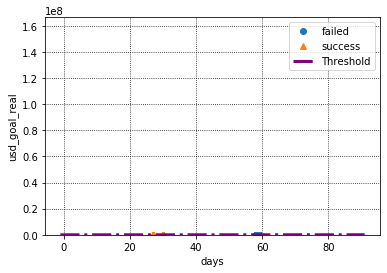

In [335]:
x1, x2 = df2["days"].values, df2["usd_goal_real"].values 

# データをプロット
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')

plt.plot(x1[y], x2[y], 'o', color='C0', label='failed')
plt.plot(x1[~y], x2[~y], '^', color='C1', label='success')

# 境界線をプロットして表示
# 紫：境界線
line_x = np.arange(np.min(x1) - 1, np.max(x1) + 1)
line_y = - line_x * w1 / w2 - w0 / w2
plt.plot(line_x, line_y, linestyle='-.', linewidth=3, color='purple', label='Threshold')
plt.ylim([np.min(x2) - 1, np.max(x2) + 1])
plt.legend(loc='best')

plt.xlabel("days")
plt.ylabel("usd_goal_real")
plt.show()

In [346]:
y = df2["state"].values
X = df2[["days", "usd_goal_real"]].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]

print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

w0 = 9675.284, w1 = 252022.975, w2 = -466.253


In [347]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -16.637
正答率 = 51.832%


In [348]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = failed', '正解 = success'], 
                        columns=['予測 = failed', '予測 = success'])
conf_mat

,予測 = failed,予測 = success
正解 = failed,54897,139450
正解 = success,17867,114389
